In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import random

device = torch.device("cpu")

In [2]:
# --------------------
# Data Preparation
# --------------------
# Define image transformations
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])


In [3]:
# Load images from dog and cat folders
dataset = datasets.ImageFolder(
    root='archive/PetImages/',  # Path to the dataset folder
    transform=transform
)

# Print the class-to-label mapping
print(dataset.class_to_idx)

# Get indices for each class (dog=0, cat=1)
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == 1]
cat_indices = [i for i, (_, label) in enumerate(dataset) if label == 0]

print("loaded all Indices")

# Define the exact number of images
num_dog_images = 5000
num_cat_images = 500

# Randomly select the specified number of images
selected_dog_indices = random.sample(dog_indices, num_dog_images)
selected_cat_indices = random.sample(cat_indices, num_cat_images)

print("sampled Indeces")

# Combine and shuffle the selected indices
selected_indices = selected_dog_indices + selected_cat_indices
random.shuffle(selected_indices)

# Create the subset dataset
subset_dataset = Subset(dataset, selected_indices)

# DataLoader
batch_size = 64
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

# Verify the dataset sizes
print(f"Number of selected images: {len(subset_dataset)}")

{'Cat': 0, 'Dog': 1}


C:\Users\Symeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loaded all Indices
sampled Indeces
Number of selected images: 5500


In [4]:
# --------------------
# GAN Architecture
# --------------------
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)

In [6]:
# Instantiate models
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [7]:
# --------------------
# Training Loop
# --------------------
epochs = 100
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Prepare data
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create labels
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Train Discriminator
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        real_loss = criterion(discriminator(real_images), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        g_loss = criterion(discriminator(fake_images), real_labels)
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [1/100] | D Loss: 0.3179 | G Loss: 3.0307
Epoch [2/100] | D Loss: 0.2614 | G Loss: 3.2718
Epoch [3/100] | D Loss: 0.7741 | G Loss: 4.0760
Epoch [4/100] | D Loss: 0.4626 | G Loss: 4.7492
Epoch [5/100] | D Loss: 0.7736 | G Loss: 2.5643
Epoch [6/100] | D Loss: 0.7360 | G Loss: 2.0279
Epoch [7/100] | D Loss: 0.5319 | G Loss: 5.4980
Epoch [8/100] | D Loss: 0.6531 | G Loss: 3.6954
Epoch [9/100] | D Loss: 0.3752 | G Loss: 3.7442
Epoch [10/100] | D Loss: 0.5441 | G Loss: 2.5741
Epoch [11/100] | D Loss: 0.4123 | G Loss: 4.0195
Epoch [12/100] | D Loss: 0.4936 | G Loss: 2.2824
Epoch [13/100] | D Loss: 0.4529 | G Loss: 2.7716
Epoch [14/100] | D Loss: 0.6736 | G Loss: 5.5565
Epoch [15/100] | D Loss: 0.3813 | G Loss: 2.7025
Epoch [16/100] | D Loss: 1.0660 | G Loss: 2.1767
Epoch [17/100] | D Loss: 0.6477 | G Loss: 4.2007
Epoch [18/100] | D Loss: 0.6664 | G Loss: 2.0046
Epoch [19/100] | D Loss: 0.2687 | G Loss: 4.1292
Epoch [20/100] | D Loss: 0.3438 | G Loss: 3.0796
Epoch [21/100] | D Loss: 0.56

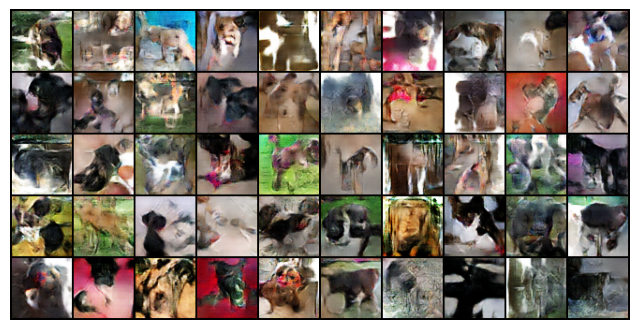

In [199]:
# --------------------
# Generate Images
# --------------------
def generate_images(generator, latent_dim, num_images=9):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, latent_dim, 1, 1, device=device)
        fake_images = generator(noise).cpu()
    return fake_images

# Generate and display 3x3 grid of images or 5x6 to get more iamges
generated_images = generate_images(generator, latent_dim, 50)
grid = utils.make_grid(generated_images, nrow=10, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()